In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import necessary packages

## Installing pandas, numpy, matplotlib, seaborn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import spacy
from wordcloud import WordCloud

from scipy.stats import zscore, iqr

# Tokenize using NLTK
nltk.download('punkt')


# Lemmatize using SpaCy
spacy_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Read Dataset

## Read csv from colab console

In [ ]:
stock_df = pd.read_csv("/content/drive/MyDrive/LJMU/Gaurav/stocks_prediction.csv")
print(f'Shape of dataframe: {stock_df.shape}')
stock_df.head()

Shape of dataframe: (29905, 7)


,Date,Open,High,Low,Close,Volume,Stock Name
0,2000-01-03,5.9,5.88,5.88,5.88,35389440000,PETR4.SA
1,2000-01-04,5.6,5.55,5.55,5.55,28861440000,PETR4.SA
2,2000-01-05,5.5,5.49,5.49,5.49,43033600000,PETR4.SA
3,2000-01-06,5.5,5.47,5.47,5.47,34055680000,PETR4.SA
4,2000-01-07,5.5,5.50,5.50,5.50,20912640000,PETR4.SA


Inference: the code loads the CSV file into the DataFrame stock_df, prints the shape of the DataFrame (number of rows and columns) as the DataFrame stock_df has 29,905 rows and 7 columns, and then displays the first 5 rows of the DataFrame to get a glimpse of the data.

In [ ]:
stock_df['Stock Name'].value_counts()

PETR4.SA    5789
VALE3.SA    5789
ABEV3.SA    5787
ITUB4.SA    5536
BBDC4.SA    3733
MGLU3.SA    2909
RAIZ4.SA     362
Name: Stock Name, dtype: int64

## Data Cleaning

### Check for missing values

In [ ]:
stock_df.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Stock Name    0
dtype: int64

No missing values

### Check for duplicates

In [ ]:
# Check for duplicates
duplicates = stock_df.duplicated()
duplicates.sum()

0

In [ ]:
stock_df_orig = stock_df.copy()

### Check for outliers

In [ ]:
# Columns containing numerical data for outlier analysis
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Function to detect outliers using z-score method
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(zscore(data))
    return z_scores > threshold

# Function to detect outliers using IQR method
def detect_outliers_iqr(data, factor=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return (data < lower_bound) | (data > upper_bound)

# Loop through numerical columns and add outlier flags to the dataset
for col in numerical_columns:
    stock_df[f'{col}_outlier_zscore'] = detect_outliers_zscore(stock_df[col])
    stock_df[f'{col}_outlier_iqr'] = detect_outliers_iqr(stock_df[col])

stock_df.sample(5)

,Date,Open,High,Low,Close,Volume,Stock Name,Open_outlier_zscore,Open_outlier_iqr,High_outlier_zscore,High_outlier_iqr,Low_outlier_zscore,Low_outlier_iqr,Close_outlier_zscore,Close_outlier_iqr,Volume_outlier_zscore,Volume_outlier_iqr
26814,2010-08-04,50.9,50.96,49.80,50.43,2657600,VALE3.SA,False,True,False,True,False,True,False,True,False,False
20523,2010-01-11,17.8,17.96,17.37,17.61,13545194,ITUB4.SA,False,False,False,False,False,False,False,False,False,False
18905,2003-08-11,3.5,3.56,3.48,3.49,97633142,ITUB4.SA,False,False,False,False,False,False,False,False,False,True
20491,2009-11-23,17.0,17.42,17.03,17.25,12952014,ITUB4.SA,False,False,False,False,False,False,False,False,False,False
2927,2011-07-07,23.7,23.79,23.55,23.63,15371600,PETR4.SA,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Determine if there are outliers in the entire DataFrame using both methods
has_outliers_zscore = any(detect_outliers_zscore(stock_df[col]).any() for col in numerical_columns)
has_outliers_iqr = any(detect_outliers_iqr(stock_df[col]).any() for col in numerical_columns)

print("Outliers detected using z-score:", has_outliers_zscore)
print("Outliers detected using IQR:", has_outliers_iqr)

Outliers detected using z-score: True
Outliers detected using IQR: True


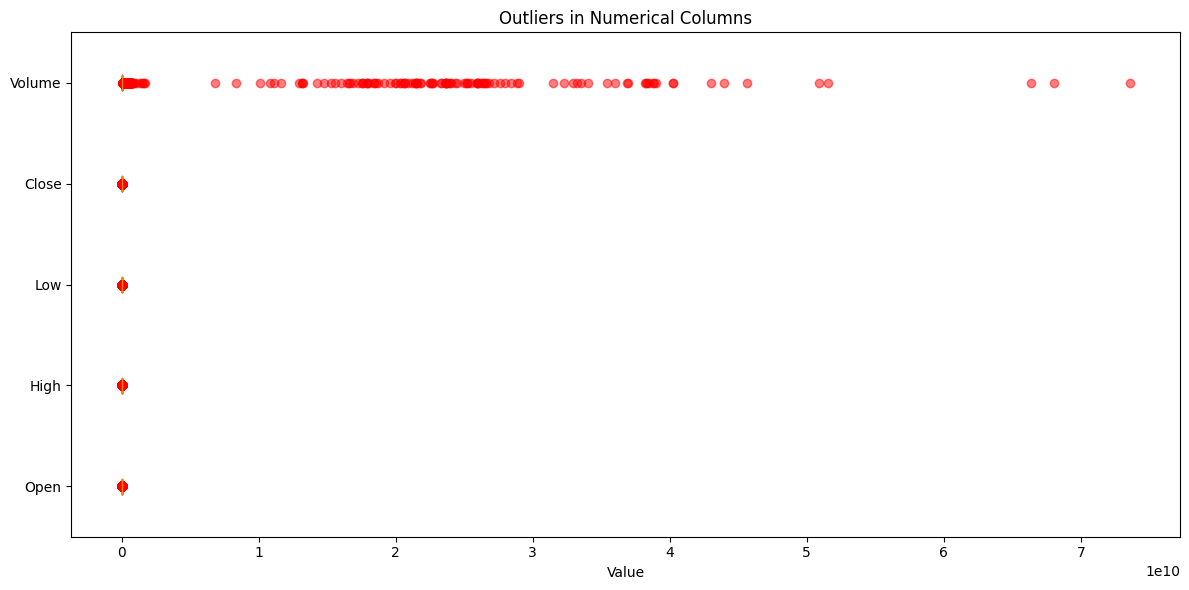

In [ ]:
# Create a figure and axis for the box plot
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Loop through numerical columns and plot box plots
for col in numerical_columns:
    outliers_iqr = detect_outliers_iqr(stock_df[col])
    ax.boxplot(stock_df[col], vert=False, positions=[numerical_columns.index(col)], showfliers=False)
    ax.plot(stock_df[col][outliers_iqr], [numerical_columns.index(col)] * sum(outliers_iqr), 'ro', alpha=0.5)


# Set labels, title, and layout
ax.set_yticks(range(len(numerical_columns)))
ax.set_yticklabels(numerical_columns)
plt.xlabel('Value')
plt.title('Outliers in Numerical Columns')
plt.tight_layout()

# Show the plot
plt.show()

### Statistical Summary

In [ ]:
data = stock_df_orig.copy()

# Calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    close_prices = data['Close'].values
    short_ema = pd.Series(close_prices).ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = pd.Series(close_prices).ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd, signal

data['MACD'], data['MACD Signal'] = calculate_macd(data)

# Calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    close_prices = data['Close'].values
    rolling_mean = pd.Series(close_prices).rolling(window=window, min_periods=1).mean()
    rolling_std = pd.Series(close_prices).rolling(window=window, min_periods=1).std()
    upper_band = rolling_mean + 2 * rolling_std
    lower_band = rolling_mean - 2 * rolling_std
    return upper_band, rolling_mean, lower_band

data['Upper Bollinger Band'], data['Middle Bollinger Band'], data['Lower Bollinger Band'] = calculate_bollinger_bands(data)

# Print the modified dataset
print(data.shape)
data.head()

(29905, 12)


,Date,Open,High,Low,Close,Volume,Stock Name,MACD,MACD Signal,Upper Bollinger Band,Middle Bollinger Band,Lower Bollinger Band
0,2000-01-03,5.9,5.88,5.88,5.88,35389440000,PETR4.SA,0.000000,0.000000,NaN,5.8800,NaN
1,2000-01-04,5.6,5.55,5.55,5.55,28861440000,PETR4.SA,-0.026325,-0.005265,6.181690,5.7150,5.248310
2,2000-01-05,5.5,5.49,5.49,5.49,43033600000,PETR4.SA,-0.051436,-0.014499,6.060000,5.6400,5.220000
3,2000-01-06,5.5,5.47,5.47,5.47,34055680000,PETR4.SA,-0.072119,-0.026023,5.980253,5.5975,5.214747
4,2000-01-07,5.5,5.50,5.50,5.50,20912640000,PETR4.SA,-0.085109,-0.037840,5.920754,5.5780,5.235246


#### Calculate summary statistics for Bollinger Bands and MACD

In [ ]:
# Calculate summary statistics for Bollinger Bands and MACD
bollinger_summary = {
    'Upper Bollinger Band Max': np.max(data['Upper Bollinger Band']),
    'Lower Bollinger Band Min': np.min(data['Lower Bollinger Band'] ),
    'Middle Bollinger Band Mean': np.mean(data['Middle Bollinger Band'])
}

macd_summary = {
    'MACD Max': np.max(data['MACD']),
    'MACD Min': np.min(data['MACD']),
    'MACD Signal Mean': np.mean(data['MACD Signal'])
}

print("Bollinger Bands Summary:")
for key, value in bollinger_summary.items():
    print(f"{key}: {value}")

print("\nMACD Summary:")
for key, value in macd_summary.items():
    print(f"{key}: {value}")

Bollinger Bands Summary:
Upper Bollinger Band Max: 119.74785759529236
Lower Bollinger Band Min: -14.704709653928433
Middle Bollinger Band Mean: 18.000391652707087

MACD Summary:
MACD Max: 6.213282121282646
MACD Min: -6.760325495695454
MACD Signal Mean: 0.01874745243255135


The summary statistics for Bollinger Bands and MACD provide insights into the behavior of these indicators for your dataset. These insights can help you make informed decisions or observations about the data. Here's what you can infer from the provided summary statistics:

Bollinger Bands Summary:

Upper Bollinger Band Max: The highest value observed for the upper Bollinger Band is 119.75. This indicates that, at its peak, the price tended to stay within this upper band.

Lower Bollinger Band Min: The lowest value observed for the lower Bollinger Band is -14.70. This suggests that the price occasionally dropped below this lower band but generally remained within its range.

Middle Bollinger Band Mean: The average value of the middle Bollinger Band is approximately 18.00. This provides an indication of the central tendency of the price movement within the bands.

MACD Summary:

MACD Max: The maximum value of the MACD is 6.21. This indicates a relatively strong bullish momentum when the MACD is at its highest.

MACD Min: The minimum value of the MACD is -6.76. This suggests a relatively strong bearish momentum when the MACD is at its lowest.

MACD Signal Mean: The average value of the MACD signal line is approximately 0.02. This provides an indication of the overall trend in the MACD signal.

Based on these summary statistics, you can make the following observations:

The price tends to stay within a certain range defined by the Bollinger Bands, with occasional spikes beyond the upper and lower bands.
The MACD values indicate periods of both bullish and bearish momentum, with relatively strong movements in both directions.

#### Visualisation

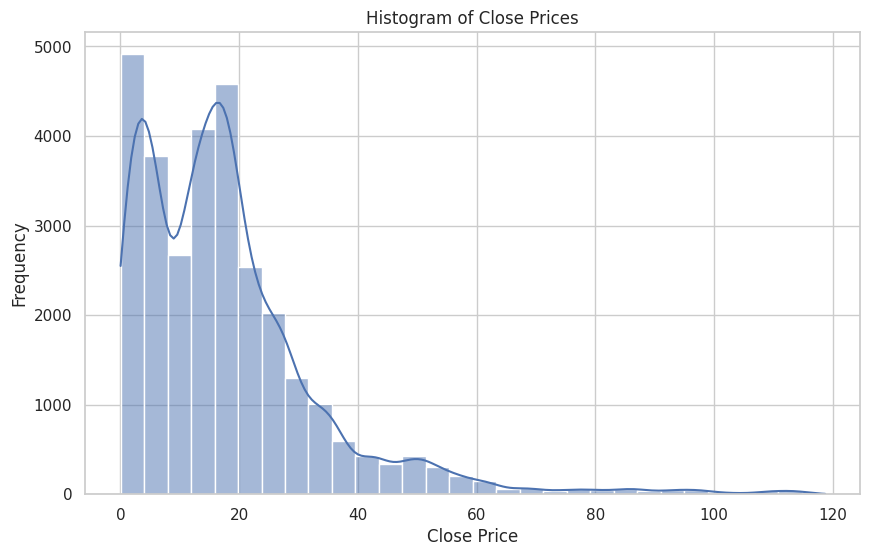

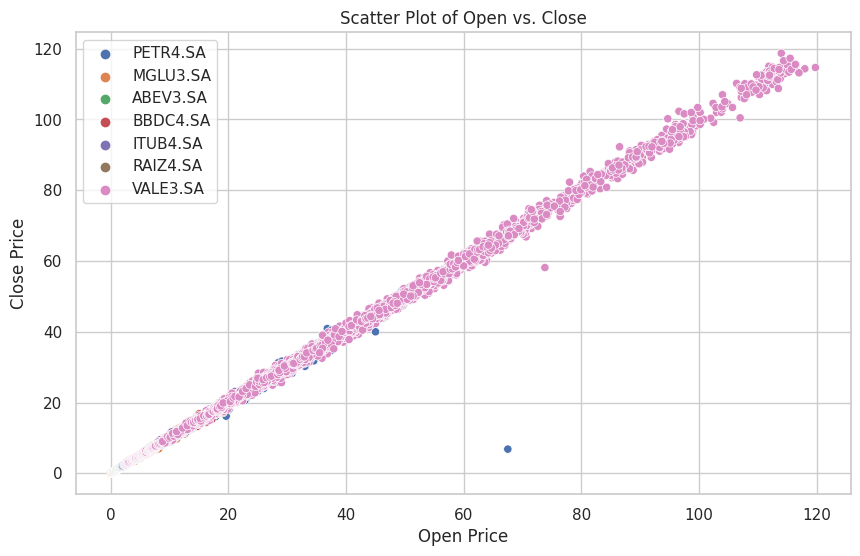

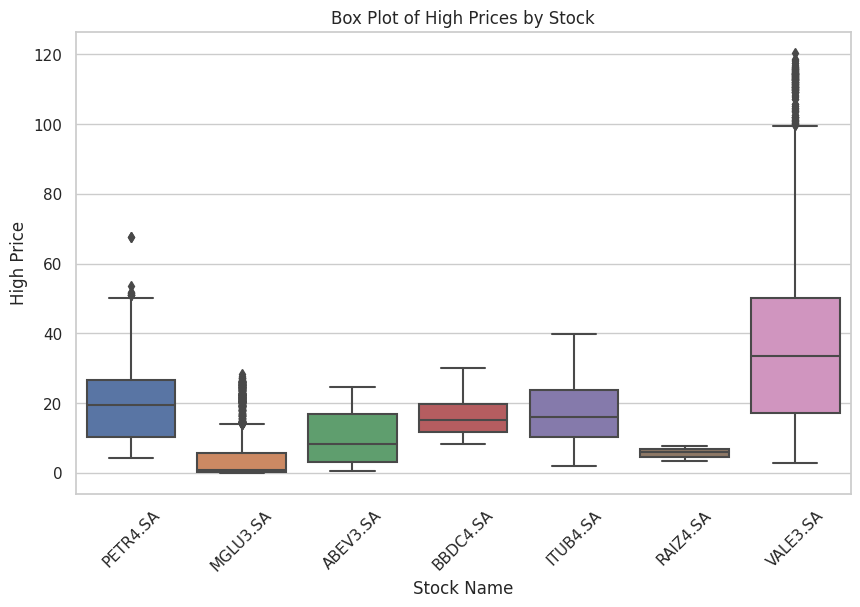

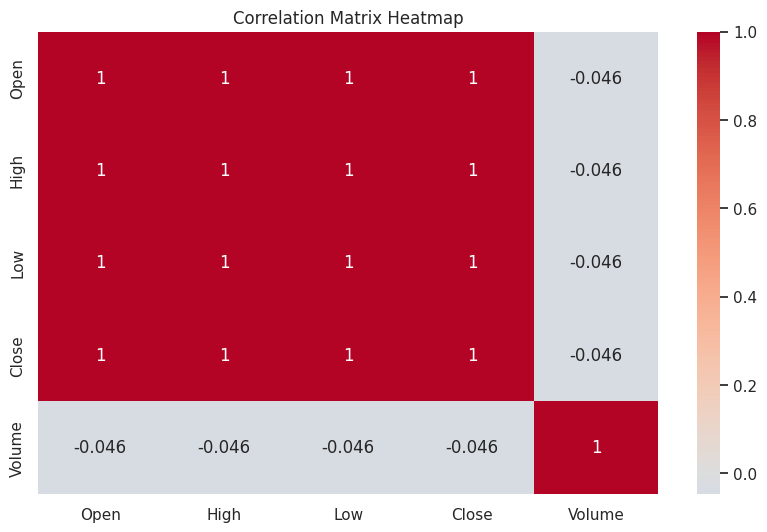

In [ ]:
data = stock_df_orig.copy()

# Set the style for the plots (optional)
sns.set(style="whitegrid")

# Plotting a histogram for 'Close' prices
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Close', bins=30, kde=True)
plt.title('Histogram of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# Creating a scatter plot of 'Open' vs. 'Close'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Open', y='Close', hue='Stock Name')
plt.title('Scatter Plot of Open vs. Close')
plt.xlabel('Open Price')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Creating a box plot of 'High' prices grouped by 'Stock Name'
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Stock Name', y='High')
plt.title('Box Plot of High Prices by Stock')
plt.xlabel('Stock Name')
plt.ylabel('High Price')
plt.xticks(rotation=45)
plt.show()

# Creating a correlation matrix heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Analyze the stationarity, trends, and seasonality in data

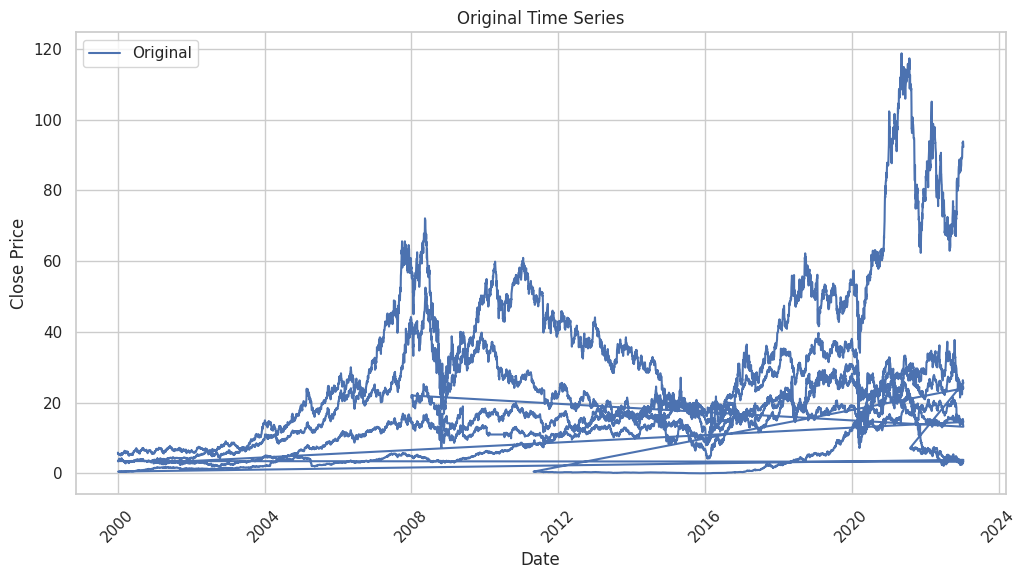

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# load data into the 'df' DataFrame
df = stock_df_orig.copy()

# Make sure 'Date' column is in datetime format and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select the 'Close' column for analysis
close_series = df['Close']

# Function to perform Augmented Dickey-Fuller test for stationarity
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(close_series, label='Original')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Perform Augmented Dickey-Fuller test for stationarity
print('Results of Augmented Dickey-Fuller Test:')
adf_test(close_series)

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -1.8946577156598072
p-value: 0.3345784484986567
Critical Values: {'1%': -3.4305690248255014, '5%': -2.861636803035758, '10%': -2.566821525304782}


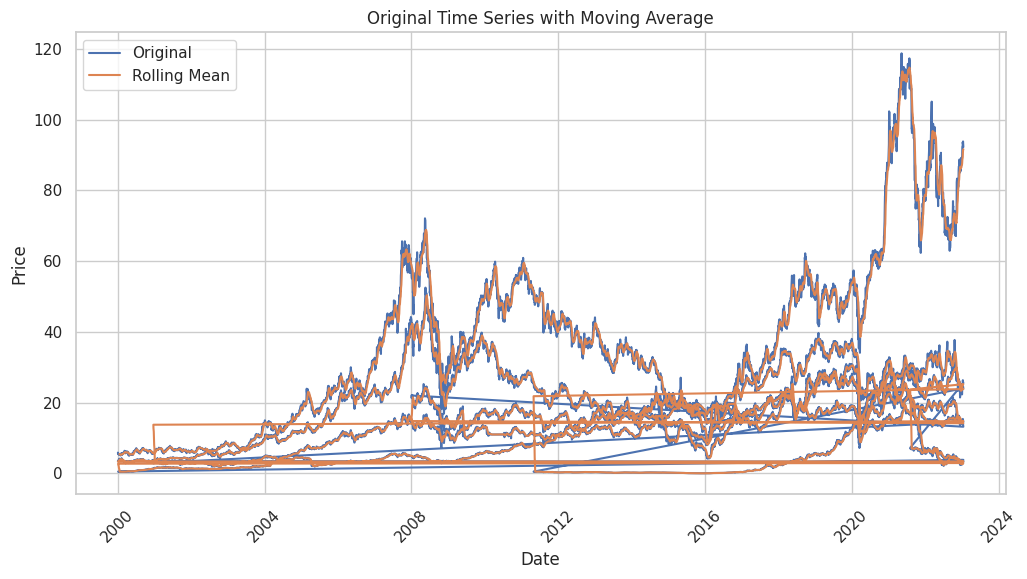

In [ ]:
# Calculate moving average and plot
rolling_mean = close_series.rolling(window=12).mean()
plt.figure(figsize=(12, 6))
plt.plot(close_series, label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.title('Original Time Series with Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

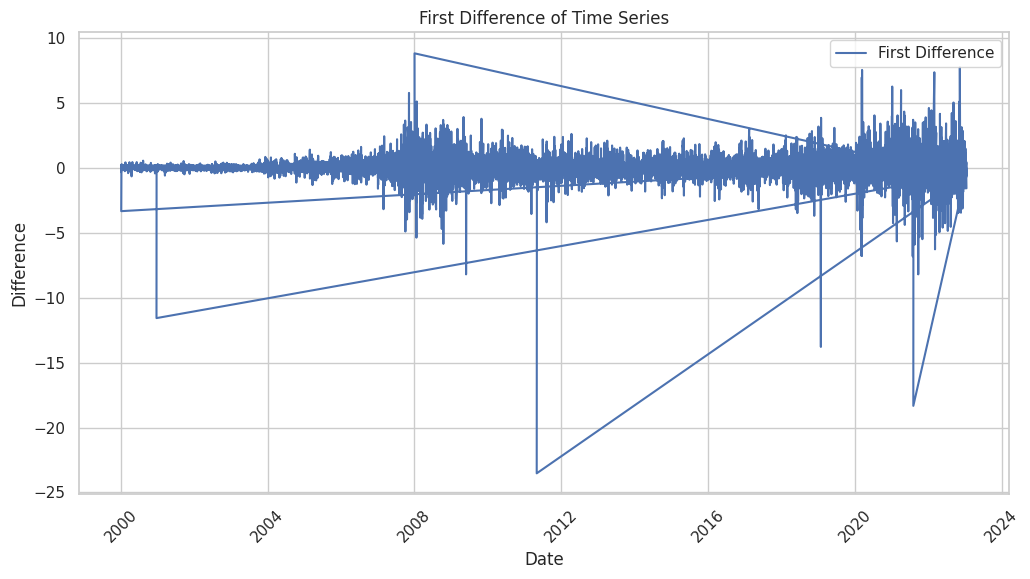

In [ ]:
# Calculate first difference and plot
diff_1 = close_series.diff(1)
plt.figure(figsize=(12, 6))
plt.plot(diff_1, label='First Difference')
plt.title('First Difference of Time Series')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Perform Augmented Dickey-Fuller test for differenced series
print('Results of Augmented Dickey-Fuller Test for First Difference:')
adf_test(diff_1.dropna())

Results of Augmented Dickey-Fuller Test for First Difference:
ADF Statistic: -23.62185128638344
p-value: 0.0
Critical Values: {'1%': -3.4305690468355157, '5%': -2.861636812763229, '10%': -2.5668215304824806}


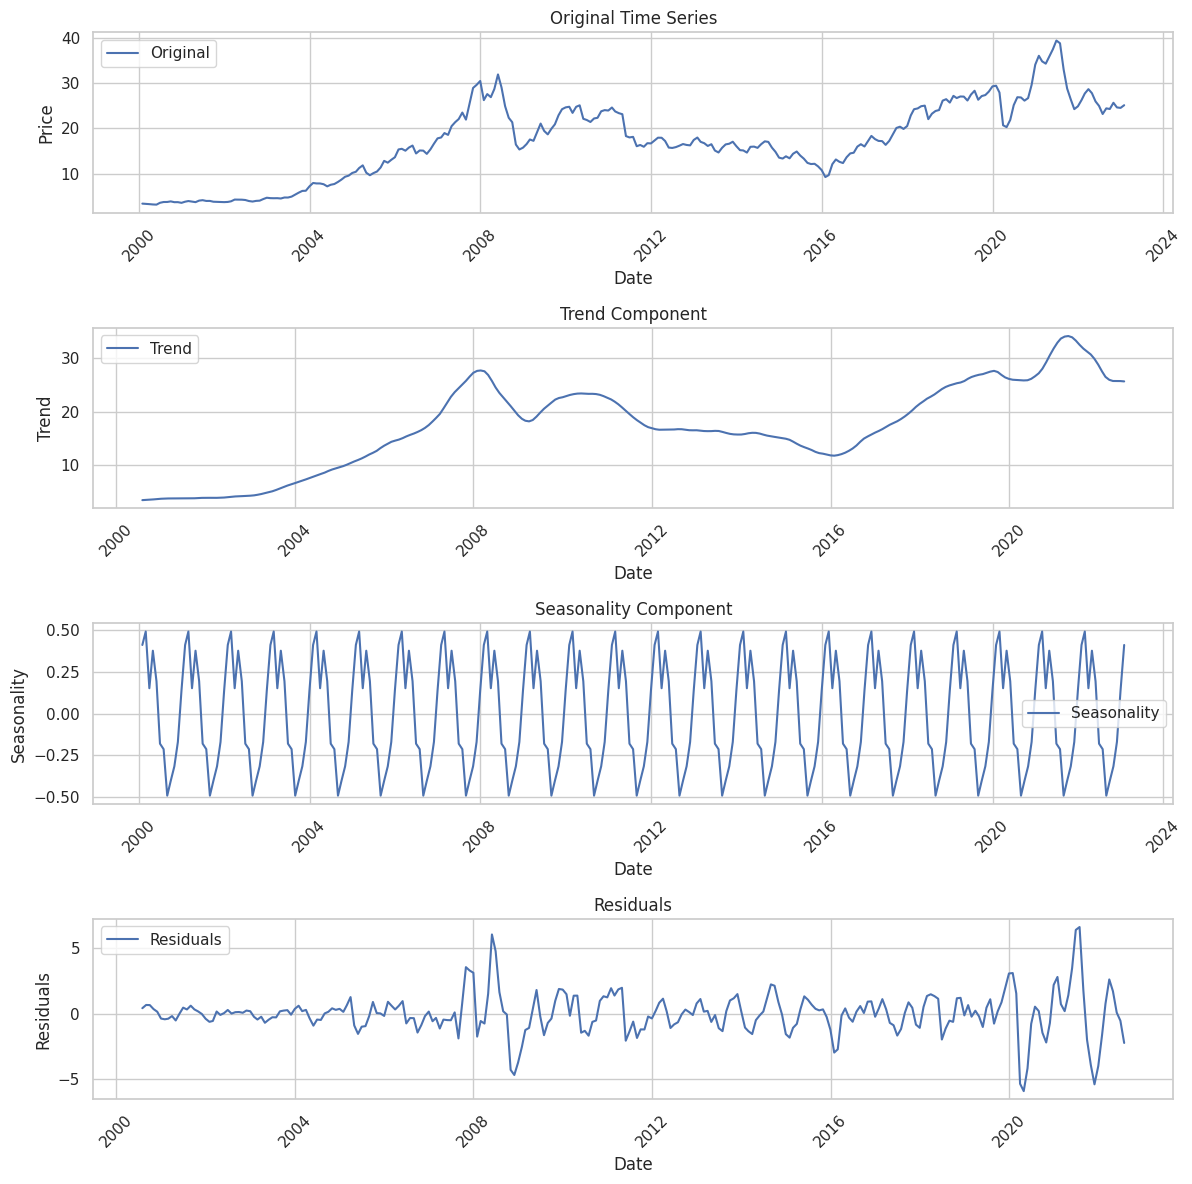

In [ ]:
# Resample the data to monthly frequency
resampled_df = df.resample('M').mean()

# Select the 'Close' column for analysis
close_series = resampled_df['Close']

# Time series decomposition
result = seasonal_decompose(close_series, model='additive')
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.plot(close_series, label='Original')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality')
plt.title('Seasonality Component')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature Selection (Correlation)

In [ ]:
stock_selected_features_df = stock_df_orig[['Date','Close','Volume','Stock Name']].copy()

## Integrated sentiment texts for stocks dataframe

In [ ]:
stocks_sentiment_df = pd.read_csv("/content/drive/MyDrive/LJMU/Gaurav/stocks_sentiment_prediction.csv")
print(f'Shape of dataframe: {stocks_sentiment_df.shape}')
stocks_sentiment_df.head()

Shape of dataframe: (5048, 10)


,Date,Open,High,Low,Close,Volume,Stock Name,tweets,sentiment,tweet_cleaned
0,2000-01-06,5.5,5.47,5.47,5.47,3.405568e+10,PETR4.SA,Whats it like being on the opposite trade of @...,1.0,whats like opposite trade probability success ...
1,2000-01-07,5.5,5.50,5.50,5.50,2.091264e+10,PETR4.SA,You are wrong. The reason $PETR4.SA stock perf...,-1.0,wrong reason PETR4.SA stock performed well pro...
2,2000-01-10,5.6,5.61,5.61,5.61,1.956352e+10,PETR4.SA,$PETR4.SA riding the #bollingerband. Keep an e...,0.0,PETR4.SA riding bollingerband keep eye reversa...
3,2000-01-11,5.5,5.47,5.47,5.47,2.398720e+10,PETR4.SA,Dude $PETR4.SA was issued 1407 vins 9 days ago...,-1.0,dude PETR4.SA issued vins days ago ramp bs bs ...
4,2000-01-13,5.3,5.32,5.32,5.32,2.638336e+10,PETR4.SA,You know what Interest Rates Local Banks will ...,0.0,know interest rates local banks charge PETR4.SA


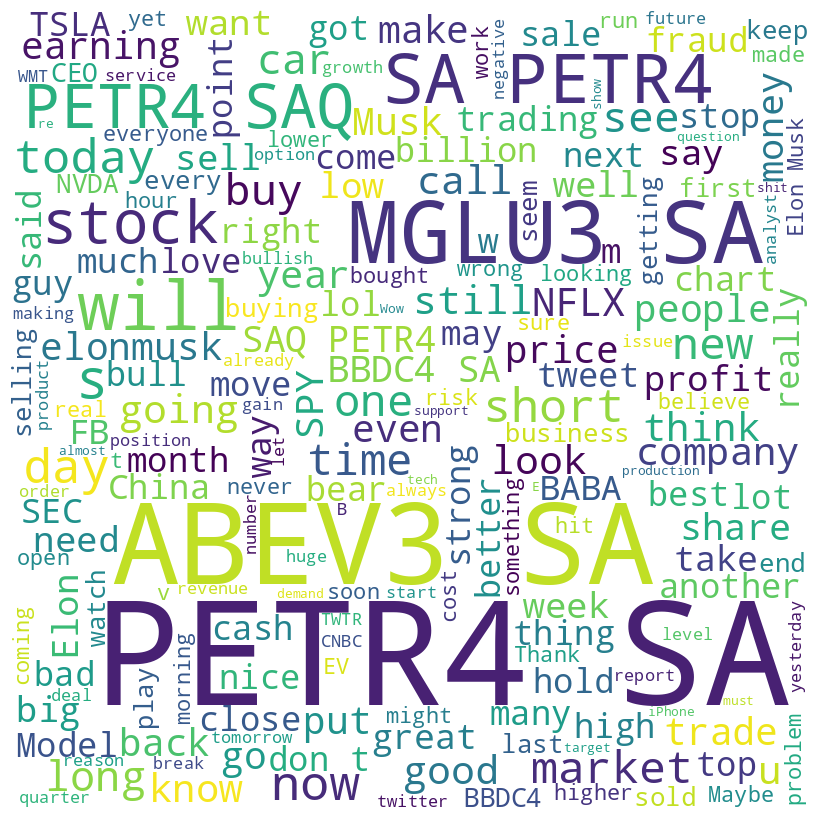

In [ ]:
# Combine the texts from 'tweets' and 'tweet_cleaned' columns
combined_tweets_text = ' '.join(stocks_sentiment_df['tweets'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(combined_tweets_text)

# Display the WordCloud using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Save the WordCloud to an image file if needed
# wordcloud.to_file("wordcloud.png")

plt.show()

In [ ]:
# Function to clean text using NLTK and SpaCy
def clean_text(text):
    # Remove URLs, special characters, and extra spaces
    cleaned_text = re.sub(r'http\S+', '', text)
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)
    cleaned_text = ' '.join(cleaned_text.split())

    words = nltk.word_tokenize(cleaned_text)

    lemmatized_words = [token.lemma_ for token in spacy_nlp(' '.join(words))]

    return ' '.join(lemmatized_words)

In [ ]:
# Clean the 'tweets' column
stocks_sentiment_df['tweets_cleaned'] = stocks_sentiment_df['tweets'].apply(clean_text)

### EDA on text data

#### Tokenization and Word Count:
Tokenization involves splitting text into individual words or tokens. Count the frequency of each token to understand the most common words in your text data.

In [ ]:
from nltk.tokenize import word_tokenize
from collections import Counter

# Tokenize the text
tokens = [word for tweet in stocks_sentiment_df['tweets'] for word in word_tokenize(tweet)]

# Count the frequency of tokens
token_counts = Counter(tokens)

# Print the most common words
print(token_counts.most_common(15))

[('$', 11310), ('.', 5111), ('PETR4.SA', 3208), ('the', 3148), (',', 3117), ('to', 2524), ('a', 2012), ('ABEV3.SA', 1812), ('is', 1706), ('#', 1643), ('and', 1561), ('of', 1516), ('@', 1326), ('in', 1315), ('!', 1224)]


#### Word Cloud:
Create a word cloud to visualize the most frequent words in the text data.

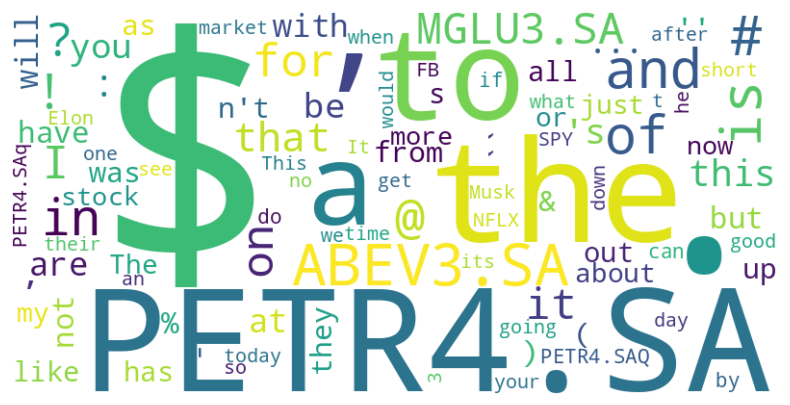

In [ ]:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(token_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

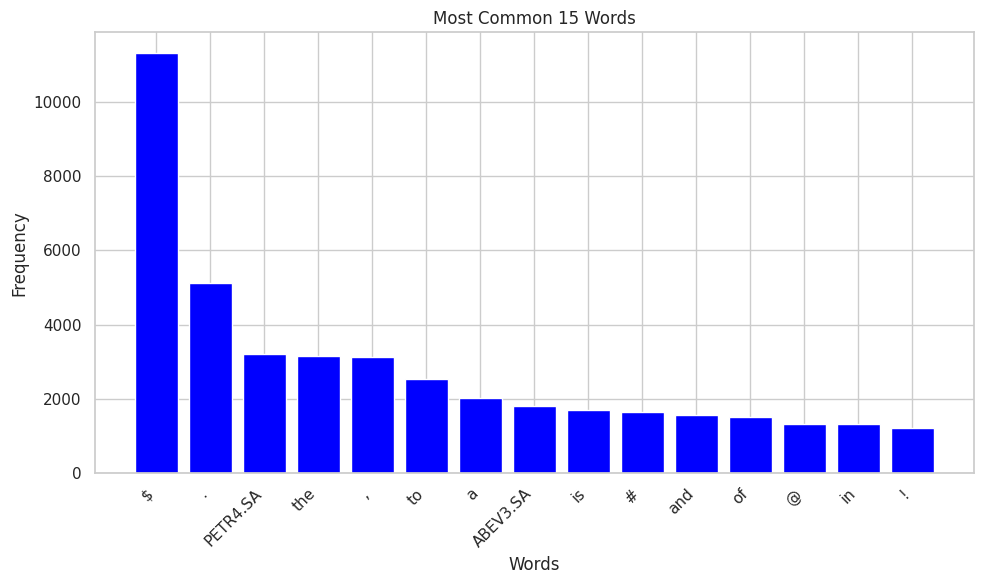

In [ ]:
# Get the most common 15 words
most_common_words = token_counts.most_common(15)

# Extract words and their counts for plotting
words = [word for word, count in most_common_words]
counts = [count for word, count in most_common_words]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common 15 Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Tokenize the text
tokens = [word for tweet in stocks_sentiment_df['tweets_cleaned'] for word in word_tokenize(tweet)]

# Count the frequency of tokens
token_counts = Counter(tokens)

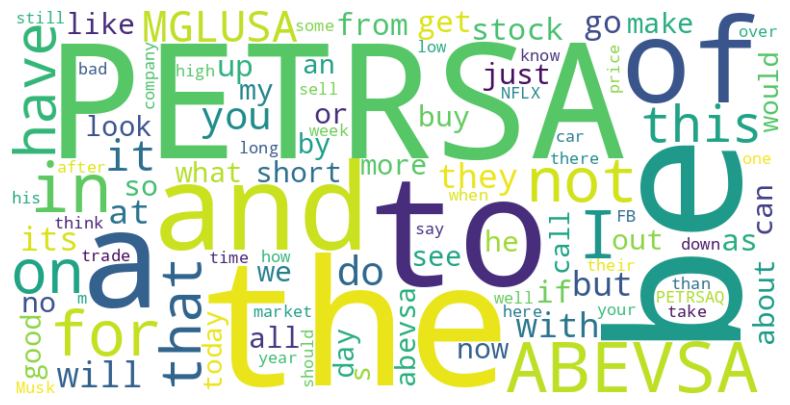

In [ ]:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(token_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

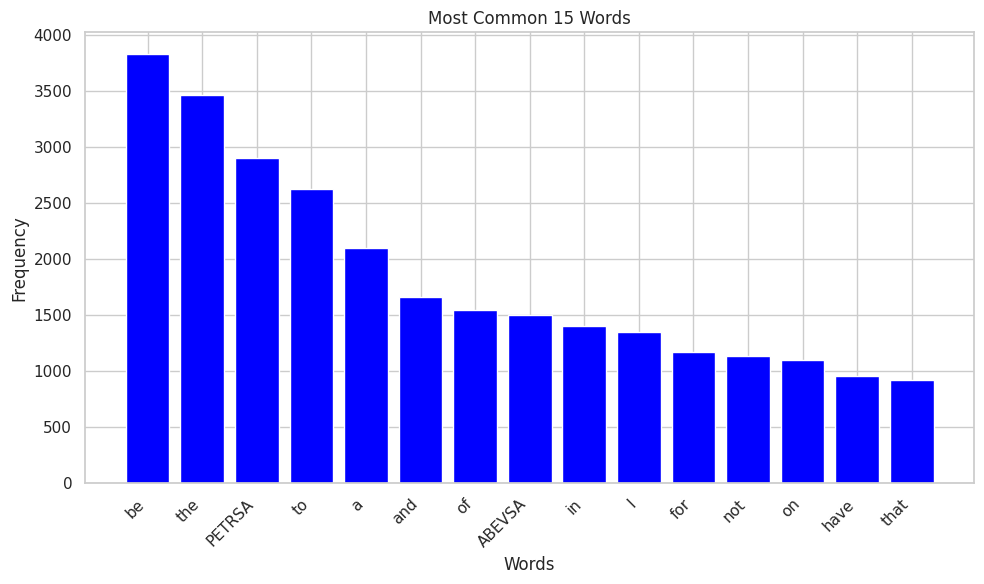

In [ ]:
# Get the most common 15 words
most_common_words = token_counts.most_common(15)

# Extract words and their counts for plotting
words = [word for word, count in most_common_words]
counts = [count for word, count in most_common_words]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common 15 Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

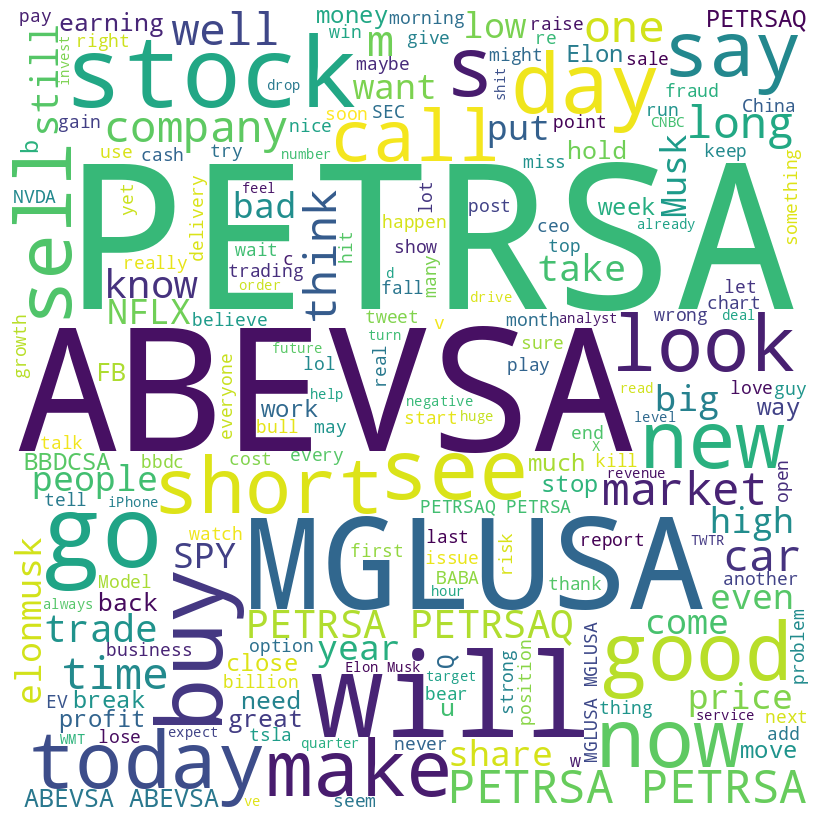

In [ ]:
# Combine the cleaned texts
combined_cleaned_text = ' '.join(stocks_sentiment_df['tweets_cleaned'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(combined_cleaned_text)

# Display the WordCloud using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Save the WordCloud to an image file if needed
# wordcloud.to_file("cleaned_wordcloud.png")

plt.show()

#### Text Length Analysis:

Analyze the distribution of text lengths to understand the typical length of tweets or articles.

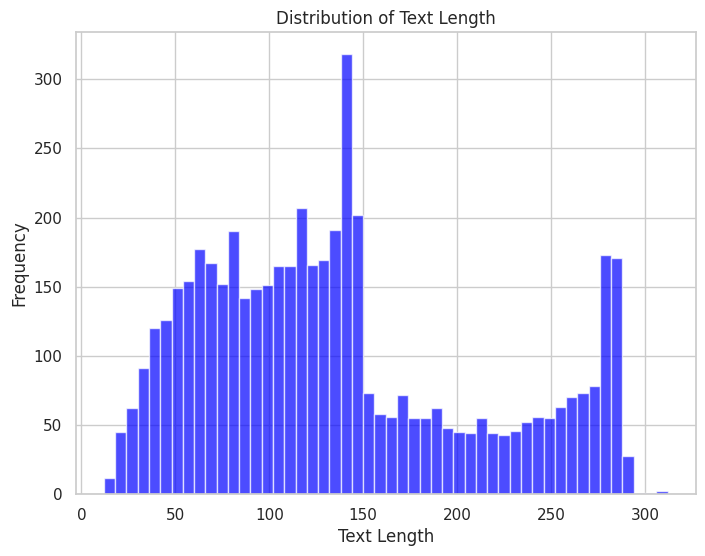

In [ ]:
# Calculate text lengths
stocks_sentiment_df['text_length'] = stocks_sentiment_df['tweets'].apply(len)

# Plot a histogram
plt.figure(figsize=(8, 6))
plt.hist(stocks_sentiment_df['text_length'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()

In [ ]:
stocks_sentiment_features_df = stocks_sentiment_df[['Date','Close','Volume','Stock Name','tweets_cleaned','sentiment']].copy()
stocks_sentiment_features_df.head()

,Date,Close,Volume,Stock Name,tweets_cleaned,sentiment
0,2000-01-06,5.47,3.405568e+10,PETR4.SA,what s it like be on the opposite trade of opt...,1.0
1,2000-01-07,5.50,2.091264e+10,PETR4.SA,you be wrong the reason PETRSA stock perform w...,-1.0
2,2000-01-10,5.61,1.956352e+10,PETR4.SA,PETRSA ride the bollingerband keep an eye out ...,0.0
3,2000-01-11,5.47,2.398720e+10,PETR4.SA,Dude PETRSA be issue vin day ago there be no R...,-1.0
4,2000-01-13,5.32,2.638336e+10,PETR4.SA,you know what Interest Rates local Banks will ...,0.0


## Question: •	How could Monte Carlo simulations assist in developing more accurate and robust hybrid models?

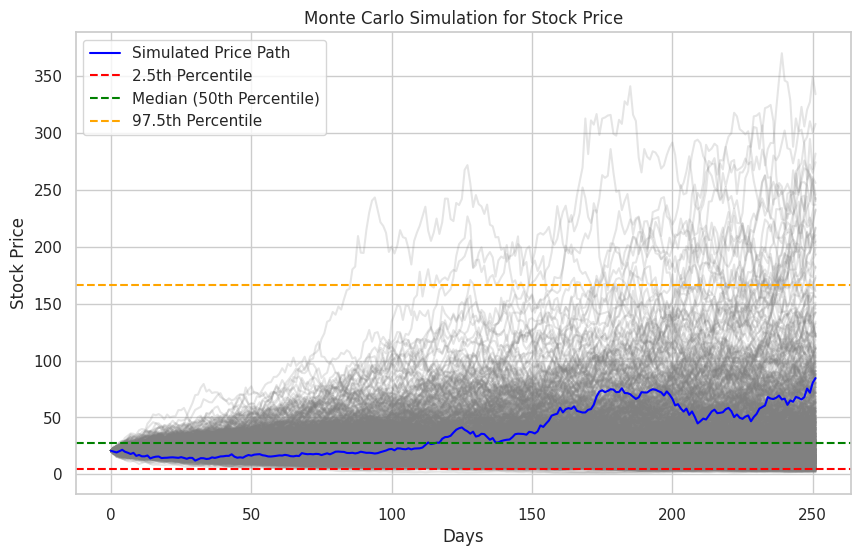

Simulated Price Statistics:
2.5th Percentile: $4.58
Median (50th Percentile): $27.94
97.5th Percentile: $166.19

Mean Final Return: 94.73%
Standard Deviation of Final Returns: 203.05%


In [ ]:
# Extract relevant data
stock_data = stocks_sentiment_features_df[['Date', 'Close', 'sentiment']]

# Calculate daily returns
stock_data['Returns'] = stock_data['Close'].pct_change()

# Calculate mean and standard deviation of daily returns
mean_return = stock_data['Returns'].mean()
std_dev_return = stock_data['Returns'].std()

# Set simulation parameters
num_simulations = 1000
num_days = 252  # Number of trading days in a year

# Initialize arrays to store simulation results
simulated_prices = np.zeros((num_days, num_simulations))
final_returns = np.zeros(num_simulations)

# Perform Monte Carlo simulations
for i in range(num_simulations):
    daily_returns = np.random.normal(mean_return, std_dev_return, num_days)
    price_series = np.zeros(num_days)
    price_series[0] = stock_data['Close'].iloc[-1]  # Starting price

    for day in range(1, num_days):
        price_series[day] = price_series[day - 1] * (1 + daily_returns[day])

    simulated_prices[:, i] = price_series
    final_returns[i] = (price_series[-1] - price_series[0]) / price_series[0]

# Calculate quantiles for simulation results
quantiles = np.percentile(simulated_prices[-1, :], [2.5, 50, 97.5])

# Plot simulation results
plt.figure(figsize=(10, 6))
plt.plot(simulated_prices, color='gray', alpha=0.2)
plt.plot(simulated_prices[:, -1], color='blue', label='Simulated Price Path')
plt.axhline(y=quantiles[0], color='red', linestyle='--', label='2.5th Percentile')
plt.axhline(y=quantiles[1], color='green', linestyle='--', label='Median (50th Percentile)')
plt.axhline(y=quantiles[2], color='orange', linestyle='--', label='97.5th Percentile')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Monte Carlo Simulation for Stock Price')
plt.legend()
plt.show()

# Display simulation results
print("Simulated Price Statistics:")
print("2.5th Percentile: ${:.2f}".format(quantiles[0]))
print("Median (50th Percentile): ${:.2f}".format(quantiles[1]))
print("97.5th Percentile: ${:.2f}".format(quantiles[2]))
print("\nMean Final Return: {:.2%}".format(final_returns.mean()))
print("Standard Deviation of Final Returns: {:.2%}".format(final_returns.std()))

## Question: What parameters and assumptions should be included in Monte Carlo simulations, such as stock price distribution, market volatility, and Black Dawn events?

In [ ]:
# Parameters
initial_price = stocks_sentiment_features_df['Close'].iloc[-1]  # The latest closing price
num_simulations = 1000  # Number of simulations to run
num_days = 30  # Number of days to forecast into the future

# Assumptions
# You can adjust these values based on your research and domain knowledge
average_daily_return = np.mean(stocks_sentiment_features_df['Close'].pct_change())
daily_volatility = np.std(stocks_sentiment_features_df['Close'].pct_change())

# Perform Monte Carlo simulations
results = []

for _ in range(num_simulations):
    daily_returns = np.random.normal(average_daily_return, daily_volatility, num_days)
    price_series = [initial_price]

    for dr in daily_returns:
        price_series.append(price_series[-1] * (1 + dr))

    results.append(price_series)

# Convert results to DataFrame
simulations_df = pd.DataFrame(results).T
simulations_df.columns = [f"Simulation_{i+1}" for i in range(num_simulations)]

# Calculate statistics on simulated prices
simulated_final_prices = simulations_df.iloc[-1, :]
mean_price = simulated_final_prices.mean()
median_price = simulated_final_prices.median()
std_dev = simulated_final_prices.std()
lower_bound = simulated_final_prices.quantile(0.025)
upper_bound = simulated_final_prices.quantile(0.975)

# Print the results
print("Simulation Results:")
print(f"Mean Final Price: {mean_price:.2f}")
print(f"Median Final Price: {median_price:.2f}")
print(f"Standard Deviation of Final Prices: {std_dev:.2f}")
print(f"95% Confidence Interval of Final Prices: [{lower_bound:.2f}, {upper_bound:.2f}]")

Simulation Results:
Mean Final Price: 22.52
Median Final Price: 21.43
Standard Deviation of Final Prices: 7.35
95% Confidence Interval of Final Prices: [10.91, 38.15]
